In [41]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import t
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
from scipy.stats import t

In [2]:
# Load the Excel file
file_path = './Grupo_3.xlsx'

# Load the sheet names
xls = pd.ExcelFile(file_path)
print(xls.sheet_names)  # This will show the available sheet names

# Load each sheet into a separate DataFrame
dfSantaAna = pd.read_excel(xls, sheet_name=xls.sheet_names[0])
dfLaFloresta = pd.read_excel(xls, sheet_name=xls.sheet_names[1])

# Optional: Show the first few rows of each DataFrame
print(dfSantaAna.head())
print(dfLaFloresta.head())

['Santa Ana', 'La Floresta']
       Fecha        Ventas
0 2023-01-01  12622.120347
1 2023-01-02  19769.873469
2 2023-01-03  20177.671875
3 2023-01-04  17454.600891
4 2023-01-05  17672.242987
       Fecha        Ventas
0 2023-01-01  14767.536664
1 2023-01-02  13889.323232
2 2023-01-03  11491.085327
3 2023-01-04  18903.512075
4 2023-01-05  13703.219431


In [4]:
#Función para agrupar las ventas por mes
def ventas_por_mes(df):
    df['Fecha'] = pd.to_datetime(df['Fecha'], dayfirst=True, errors='coerce')
    df['mes'] = df['Fecha'].dt.month
    return df

In [5]:
dfLaFloresta_mensual = ventas_por_mes(dfLaFloresta)
dfSantaAna_mensual = ventas_por_mes(dfSantaAna) 

In [36]:
#Funcion para graficar las ventas por mes de acuerdo a la funcion requerida
def plot_por_mes(df1, tienda1, df2, tienda2, plot_type='kde'):
    # Ver que tengan las columnas requeridas
    required_columns = ['mes', 'Ventas']
    if not all(col in df1.columns for col in required_columns) or not all(col in df2.columns for col in required_columns):
        raise ValueError("Both DataFrames must have 'mes' and 'Ventas' columns")
    
    meses = df1['mes'].unique()
    meses = sorted(meses)
    
    plt.figure(figsize=(15, 10))
    
    # reducimos la notación de los valores para no comprimir el gráfico (e.g., 1000 -> 1K)
    def thousands_formatter(x, pos):
        if x >= 1000:
            return f'{int(x/1000)}K'
        return f'{int(x)}'
    
    for i, mes in enumerate(meses, 1):
        ventas1_mes = df1[df1['mes'] == mes]['Ventas'].dropna()
        ventas2_mes = df2[df2['mes'] == mes]['Ventas'].dropna()
        
        if len(ventas1_mes) == 0 and len(ventas2_mes) == 0:
            continue  # Verificar que haya datos para el mes
        
        plt.subplot(3, 4, i)
        
        if plot_type == 'kde':
            sns.kdeplot(ventas1_mes, color='blue', fill=True, label=tienda1 if i == 1 else None)
            sns.kdeplot(ventas2_mes, color='orange', fill=True, label=tienda2 if i == 1 else None)
        elif plot_type == 'ecdf':
            # Calcular la ECDF
            sns.ecdfplot(data=ventas1_mes, color='blue', label=tienda1 if i == 1 else None)
            sns.ecdfplot(data=ventas2_mes, color='orange', label=tienda2 if i == 1 else None)   
        elif plot_type == 'densidad':
            sns.histplot(ventas1_mes, color='blue', alpha=1, label=tienda1 if i == 1 else None)
            sns.histplot(ventas2_mes, color='orange', alpha=0.3, label=tienda2 if i == 1 else None)
        else:
            raise ValueError("Invalid plot type. Choose 'kde', 'ecdf', or 'densidad'.")
        
        
        plt.title(f'Mes {mes}')
        plt.xlabel('Ventas')
        plt.ylabel('F(x)')
        plt.grid(True)
        
        # Convertir el eje X con la reducción de miles 
        plt.gca().xaxis.set_major_formatter(FuncFormatter(thousands_formatter))
        # setear el número máximo de ticks en el eje X
        plt.gca().xaxis.set_major_locator(plt.MaxNLocator(5))
        # setear el número máximo de ticks en el eje Y
        plt.xticks(rotation=45, fontsize=8)
    
    plt.tight_layout(pad=3.0)
    # Agregar título general del gráfico
    plt.figlegend(
        loc='upper center',
        bbox_to_anchor=(0.5, 1.05),
        ncol=2,
        fontsize=12,
        title=f"{tienda1} vs {tienda2} ",
        title_fontsize=14,
        frameon=True,
        edgecolor='black'
    )
    plt.show()

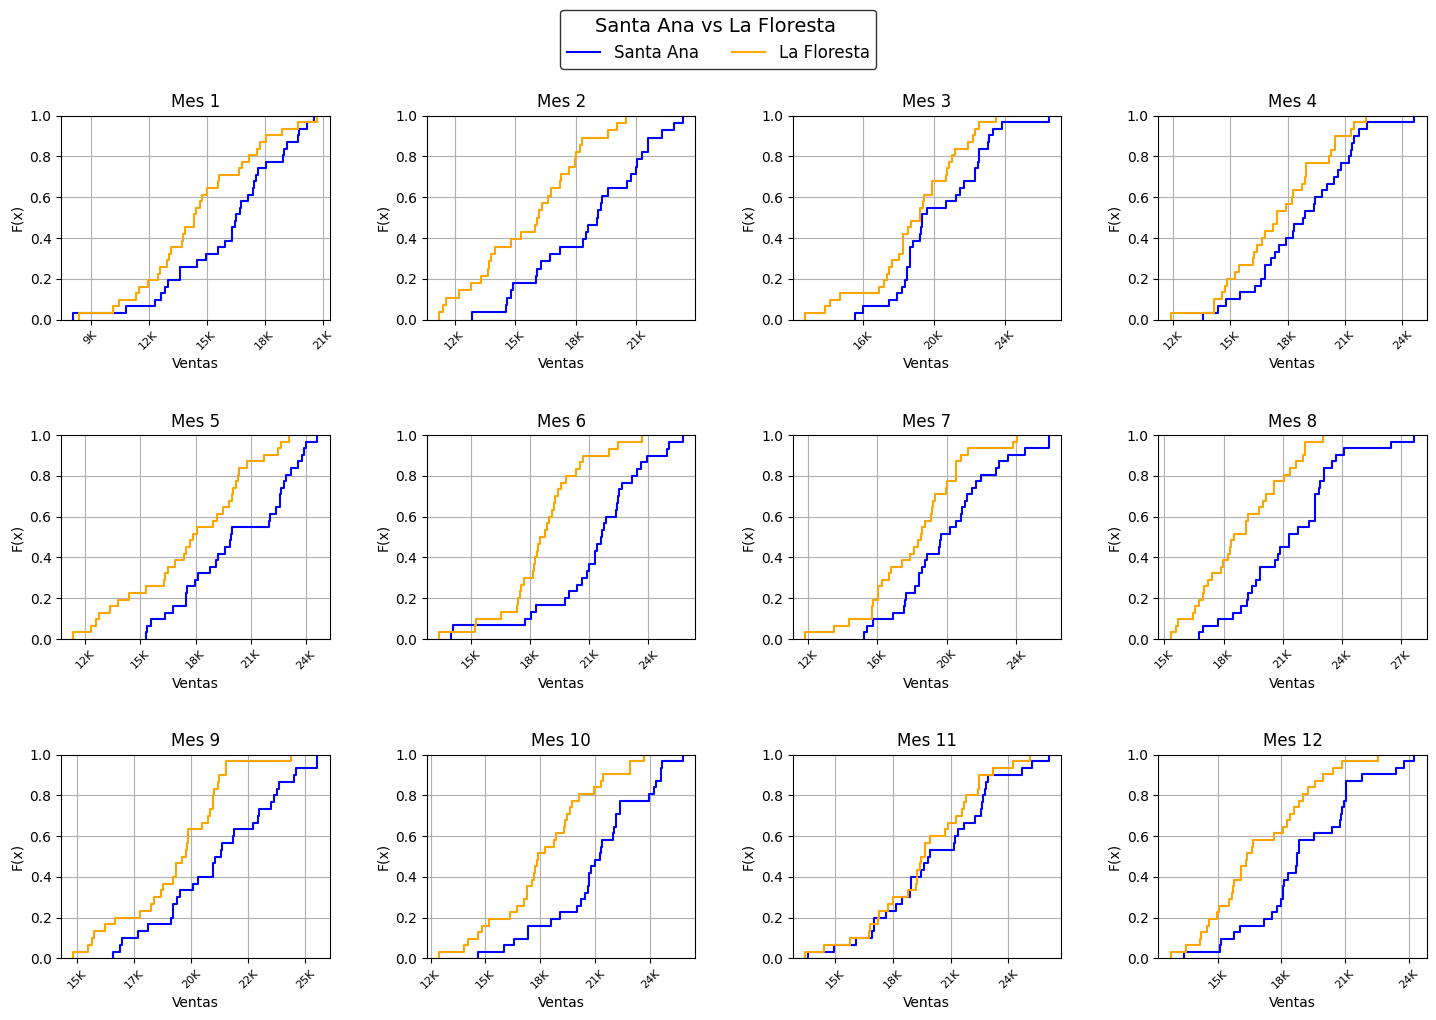

In [37]:
plot_por_mes(dfSantaAna_mensual, 'Santa Ana', dfLaFloresta_mensual, 'La Floresta', 'ecdf')

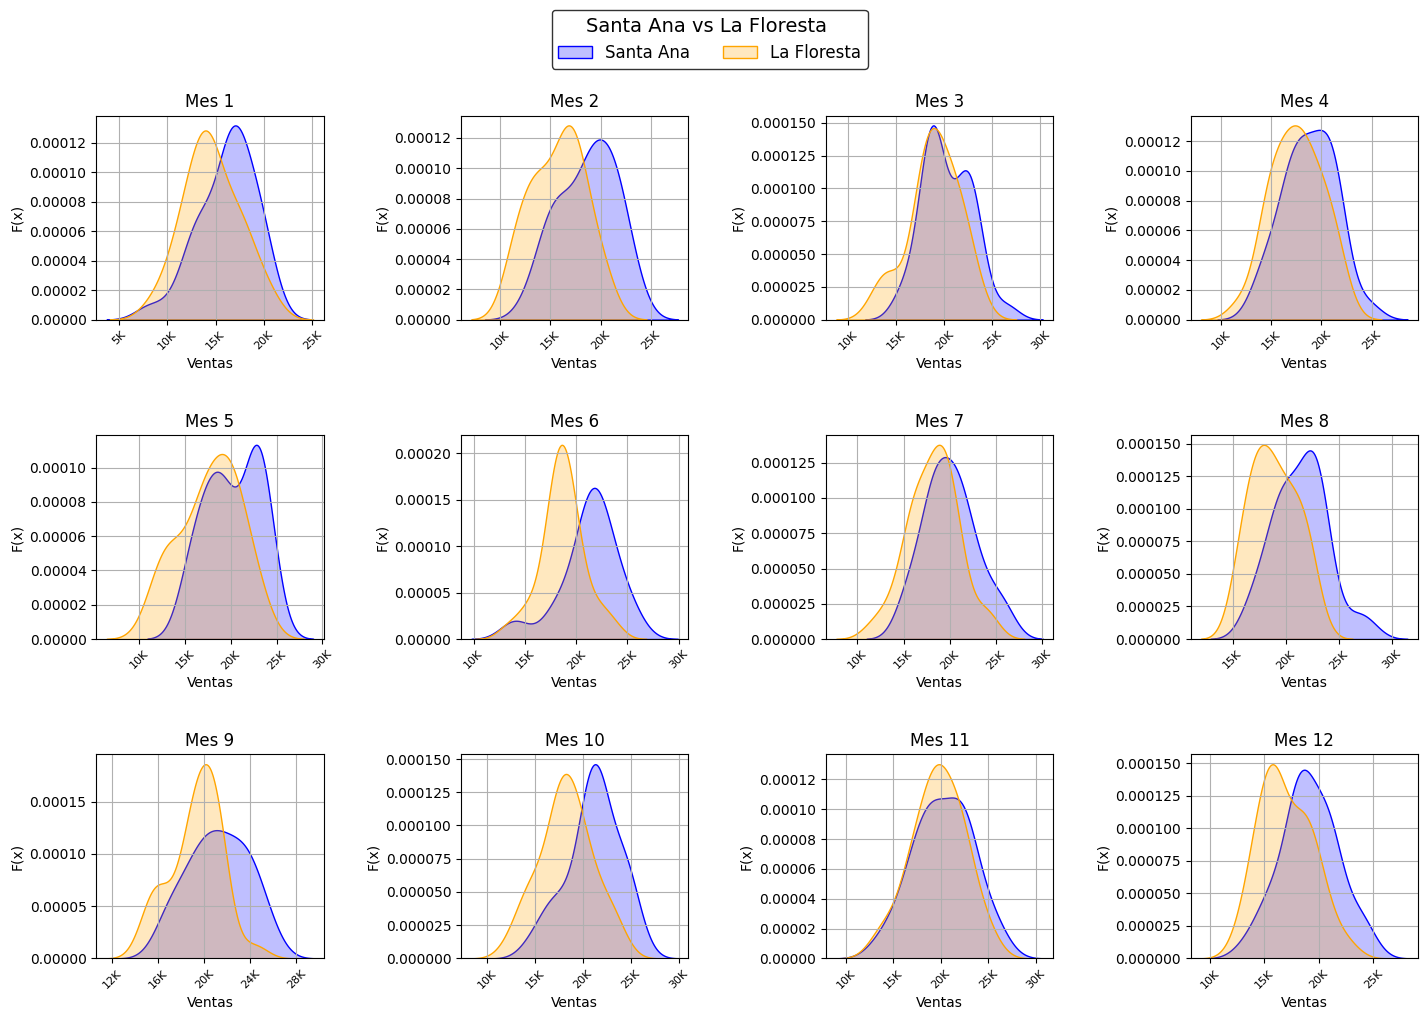

In [33]:
plot_por_mes(dfSantaAna_mensual, 'Santa Ana', dfLaFloresta_mensual, 'La Floresta', 'kde')

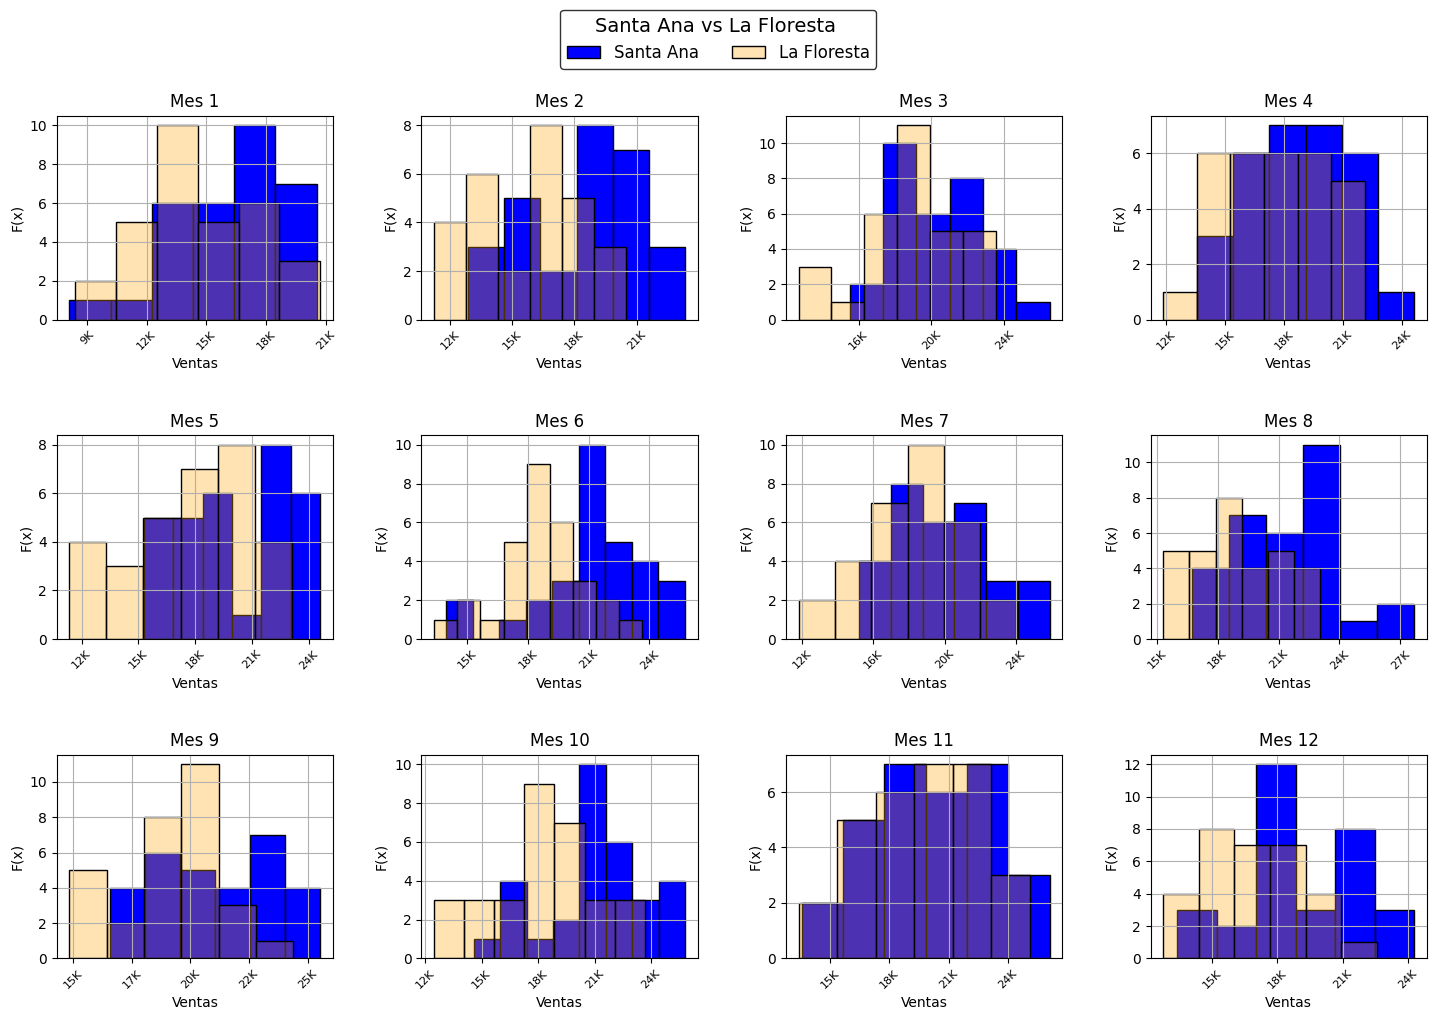

In [38]:
plot_por_mes(dfSantaAna_mensual, 'Santa Ana', dfLaFloresta_mensual, 'La Floresta', 'densidad')

In [44]:

# Cálculo de intervalos de confianza por medio de la distribución t de Student
ventas_mes = np.array([...])
n = len(ventas_mes)
media = np.mean(ventas_mes)
desv = np.std(ventas_mes, ddof=1)

# Intervalo de confianza al 95%
alpha = 0.05
t_crit_95 = t.ppf(1 - alpha/2, df=n-1)
margen_error_95 = t_crit_95 * (desv / np.sqrt(n))
ic_95 = (media - margen_error_95, media + margen_error_95)

# Intervalo de confianza al 99%
alpha = 0.01
t_crit_99 = t.ppf(1 - alpha/2, df=n-1)
margen_error_99 = t_crit_99 * (desv / np.np.sqrt(n))
ic_99 = (media - margen_error_99, media + margen_error_99)
print(f"Intervalo de confianza al 95%: {ic_95}")
print(f"Intervalo de confianza al 99%: {ic_99}")
# Cálculo de intervalos de confianza por medio de la distribución normal

TypeError: unsupported operand type(s) for /: 'ellipsis' and 'int'

In [58]:
def plot_tsudent_por_mes(df, tienda):
    meses = df['mes'].unique()
    meses = sorted(meses)

    for i, mes in enumerate(meses, 1):
        ventas_mes = df[df['mes'] == mes]['Ventas'].dropna()
        n = len(ventas_mes)
        media = np.mean(ventas_mes)
        desv = np.std(ventas_mes, ddof=1)
        # Intervalo de confianza al 95%
        alpha = 0.05
        t_crit_95 = t.ppf(1 - alpha/2, df=n-1)
        margen_error_95 = t_crit_95 * (desv / np.sqrt(n))
        ic_95 = (media - margen_error_95, media + margen_error_95)
        print(f"Intervalo de confianza al 95% para {tienda} - Mes {mes}: {ic_95}")
        # Intervalo de confianza al 99%
        alpha = 0.01
        t_crit_99 = t.ppf(1 - alpha/2, df=n-1)
        margen_error_99 = t_crit_99 * (desv / np.sqrt(n))
        ic_99 = (media - margen_error_99, media + margen_error_99)
        print(f"Intervalo de confianza al 99% para {tienda} - Mes {mes}: {ic_99}")

In [59]:
plot_tsudent_por_mes(dfSantaAna, 'Santa Ana')

Intervalo de confianza al 95% para Santa Ana - Mes 1: (np.float64(15049.02470569485), np.float64(17196.774008720196))
Intervalo de confianza al 99% para Santa Ana - Mes 1: (np.float64(14676.887286181449), np.float64(17568.911428233598))
Intervalo de confianza al 95% para Santa Ana - Mes 2: (np.float64(17546.930739563802), np.float64(19751.396272894963))
Intervalo de confianza al 99% para Santa Ana - Mes 2: (np.float64(17160.76691749937), np.float64(20137.560094959394))
Intervalo de confianza al 95% para Santa Ana - Mes 3: (np.float64(19372.550914425905), np.float64(21205.075996478663))
Intervalo de confianza al 99% para Santa Ana - Mes 3: (np.float64(19055.031940368695), np.float64(21522.594970535873))
Intervalo de confianza al 95% para Santa Ana - Mes 4: (np.float64(17806.619944176855), np.float64(19738.86319101556))
Intervalo de confianza al 99% para Santa Ana - Mes 4: (np.float64(17470.68532453917), np.float64(20074.797810653246))
Intervalo de confianza al 95% para Santa Ana - Mes 5